# Hazard assessment: response surface methodology

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

In this second notebook of the workflow, we make use of all perturbed FWI simulations in the dataset after exploring the properties of a single simulation in the previous [historical climate](hazard_assessment_historical.ipynb) notebook.
We construct a response model of Fire Weather Index (FWI) extreme with respect to temperature, following the approach of [El Garroussi et al. (2024)](https://doi.org/10.1038/s41612-024-00575-8).

## Preparation work

### Load libraries

:::{admonition} Information about the libraries used in this workflow
:class: hint dropdown

- [pathlib](https://docs.python.org/3/library/pathlib.html) - Convenient file path manipulation.
- [json](https://docs.python.org/3/library/json.html) - General data en- and decoding, used to save the workflow configuration to disk.
- [pickle](https://docs.python.org/3/library/pickle.html) - Python-specific object en- and decoding, used to save the response model to disk.
- [numpy](https://numpy.org/) - A powerful library for numerical computations, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [xarray](https://docs.xarray.dev/en/stable/) - Library for working with labelled multi-dimensional arrays.
- [sklearn (scikit-learn)](https://scikit-learn.org/stable/index.html) - Machine learning.
- [earthkit.meteo](https://earthkit-plots.readthedocs.io/en/latest/) - Meteorological computations and statistical analysis.
- [earthkit.plots](https://earthkit-plots.readthedocs.io/en/latest/) - Visualisation tools and templates designed for earth science data.
:::

In [1]:
import json
import pathlib
import pickle

import earthkit.meteo.stats as ekm_stats
import earthkit.plots as ekp
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

### Set location

Used for labelling and to locate data from previous steps of the workflow.

In [ ]:
location = "Andalucía"

### Path configuration

In [2]:
data_dir = pathlib.Path("./data")

## Step 1: Load FWI timeseries

Load the FWI timeseries for all simulation for the given location.
These were exported in the [historical climate](hazard_assessment_historical.ipynb) hazard assessment notebook.

In [3]:
location_fwi = xr.open_dataarray(data_dir / location / "fwi_timeseries.nc")
location_fwi

<xarray.DataArray 'fwinx' (dp: 6, dt: 6, time: 10957)> Size: 3MB
[394452 values with dtype=float64]
Coordinates:
  * dt          (dt) float64 48B 0.0 1.0 2.0 3.0 4.0 5.0
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * time        (time) datetime64[ns] 88kB 1981-01-01 1981-01-02 ... 2010-12-31
    valid_time  (time) datetime64[ns] 88kB ...
  * dp          (dp) float64 48B -40.0 -20.0 0.0 20.0 40.0 60.0

## Step 2: Threshold selection

Response surface models are constructed for the probability of exceedance of a FWI threshold (step 3) and the length of the fire season (step 4), also defined by the exceedance of a FWI threshold.
The FWI threshold to be used in the analysis can be freely chosen:

In [4]:
threshold = 60.

:::{tip}

Adapt the threshold to your chosen location and interest.
You can use local expertise and information from the FWI timeseries exploration in the [historical climate](hazard_assessment_historical.ipynb) notebook to find a meaningful value for your application.
:::

Because the fitted statistical model of yearly FWI maxima also provides information outside of the range covered by the input dataset (in particular for FWI thresholds with return periods longer than the span of the dataset), any threshold value will work in the following response surface analysis.
Nevertheless, we compute the range of FWI values fully covered by the input dataset to be aware of when we are extrapolating outside of this range based on the statistical model:

In [5]:
# FWI maximum of each year for all simulations
fwi_max = location_fwi.groupby(location_fwi.coords["time"].dt.year).max()

In [6]:
# Overall smallest valid is largest of all smallest across simulations
upper_range = float(fwi_max.max(dim="year").min())
# Overall largest valid is smallest of all largest across simulations
lower_range = float(fwi_max.min(dim="year").max().values)

print(f"The input data range covers FWI values from {lower_range:.3f} to {upper_range:.3f}")

The input data range covers FWI values from 55.462 to 67.259


## Step 3: Response surface for probability of exceedance

We fit a response surface for the probability of exceedance (PE) of this threshold to data from the (unperturbed and perturbed) historical FWI simulations.
The fitted response surface allows us to estimate the probability of exceedance as a function of temperature and precipitation perturbations to the historical climate.

Fit a statistical model to yearly FWI maxima for all simulations:

In [7]:
fwi_dist = ekm_stats.GumbelDistribution.fit(fwi_max, axis=-1)

Use the statistical model to compute the probability of exceedance of the threshold:

In [8]:
# Multiply probability by 100 for values in %
pe = 100. * fwi_dist.cdf(threshold)

### Response table

The 2-dimensional array of exceedance probabilities is already our discrete response surface.
We package it as a conveniently accessible table:

In [9]:
pe_response = (
    pd.DataFrame.from_records(
        pe,
        index=fwi_max.coords["dp"].to_series(),
        columns=fwi_max.coords["dt"].to_series()
    )
    .stack()
    .rename("PE")
)

# Display table
pe_response.unstack().round(1)

dt,0.0,1.0,2.0,3.0,4.0,5.0
dp,,,,,,
-40.0,25.4,32.8,41.5,51.3,61.9,72.4
-20.0,22.4,29.2,37.5,47.0,57.5,68.3
0.0,19.9,26.2,33.9,43.1,53.5,64.4
20.0,18.0,23.8,31.1,39.9,49.9,60.9
40.0,16.4,21.9,28.8,37.2,47.0,57.9
60.0,15.1,20.2,26.7,34.7,44.3,55.0


For example, from a response table where

```
   dt   0.0   1.0   2.0
   dp
-20.0    28    32    41
  0.0    23    26    27
 20.0    11    15    26
```

we can see that the probability of exceedance of the selected FWI threshold in a year is estimated to increase from 23% to 27% in a climate that is 2°C warmer (`dp=0.0`, `dt=2.0`) than the (unperturbed) historical climate (`dp=0.0`, `dt=0.0`).
If temperatures remain unperturbed compared to the historical reference period (`dt=0.0`) but precipitation increases by 20% instead (`dp=20.0`), the probability of exceedance decreases to 11%.

Importantly, the response surface captures **synergistic** and **antagonistic** effects.
In a climate with 20% more precipitation *and* 2°C warming relative to the historical reference, the PE for the selected FWI threshold *increases* by 3% (to 26%) according to the table in the example.
In contrast, a naive addition of the individual effects of precipitation (decrease by 12%) and temperature (increase by 4%) as determined above would have suggested an overall decrease.

:::{note}
To convert the probability of exceedance to a return period, take the reciprocal.
E.g., the corresponding return period for a probability of exceedance of 23% is
$$\frac{1}{23\%} = \frac{1}{0.23} = 4.348,$$
i.e., about 4 years and 127 days.
:::

We colour the table to get a quick visual overview of the PE estimates for all perturbed simulations (note the flipped y/dp axis in the plot compared to the table):

Text(0, 0.5, 'Precipitation change (%)')

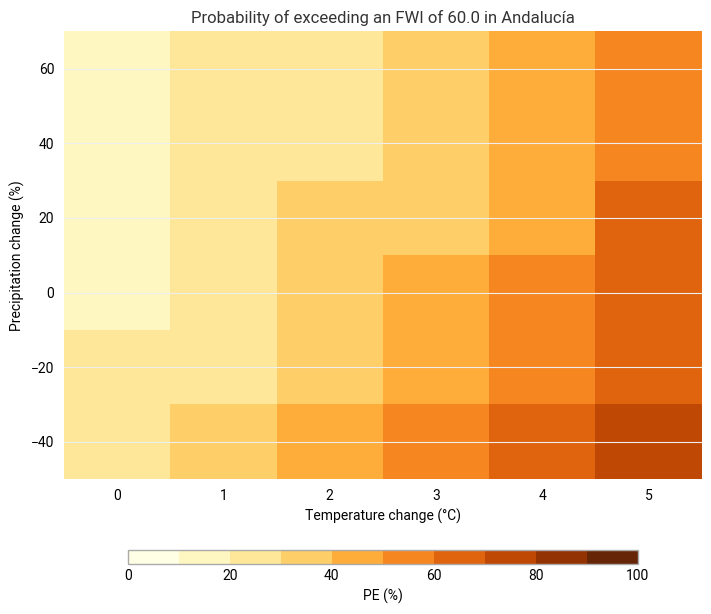

In [10]:
pe_plot_style_absolute = ekp.styles.Style(
    levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    colors="YlOrBr",
    units_label="%"
)

subplot = ekp.Subplot()
subplot.title(f"Probability of exceeding an FWI of {threshold} in {location}")

subplot.block(pe_response.to_xarray(), style=pe_plot_style_absolute)
subplot.legend()

subplot.ax.set_xlabel("Temperature change (°C)")
subplot.ax.set_ylabel("Precipitation change (%)")

### Response surface

While the colorized table above already gives a good impression of the underlying response surface, we can enhance the visualization by fitting a continuous surface to the data points from the table.

In [11]:
def fit_response_surface(data, y, x1="dp", x2="dt", degree=4):
    # Data prepared for regression
    df = data.reset_index()
    # Polynomial regression
    model = make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression()
    )
    model.fit(df[[x1, x2]], df[[y]])
    return model

In [12]:
pe_response_model = fit_response_surface(pe_response, "PE", degree=4)

To create a smooth representation of the response surface, the fitted function is sampled densely in the space spanned by the temperature and precipitation perturbations:

In [13]:
sample = pd.MultiIndex.from_product([
    np.linspace(-40, 60, 201),
    np.linspace(0.0, 5.0, 201)
], names=["dp", "dt"])

pe_response_sampled = pd.DataFrame(
    pe_response_model.predict(sample.to_frame()),
    index=sample,
    columns=["PE"]
).to_xarray()

A contour plot visualizes the response surface:

Text(0, 0.5, 'Precipitation change (%)')

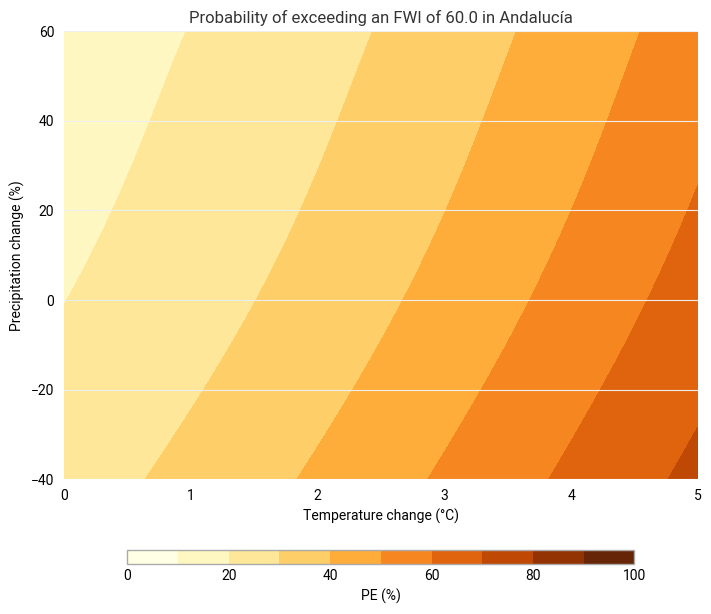

In [14]:
subplot = ekp.Subplot()
subplot.title(f"Probability of exceeding an FWI of {threshold} in {location}")

subplot.contourf(pe_response_sampled, style=pe_plot_style_absolute)
subplot.legend()

subplot.ax.set_xlabel("Temperature change (°C)")
subplot.ax.set_ylabel("Precipitation change (%)")

:::{caution}

The preconfigured 4th-degree polynomial model for the response surface can produce probabilities of exceedance outside of the range 0 to 100%.
A different model should be chosen if the fitted surface does not represent the response table appropriately.
:::

### Interpretation

The contours of the response surface tell us about the **dependencies** of the estimated response:

- Horizontal contour lines indicate that the response of PE is independent of temperature and only a function of precipitation.
- Vertical contour lines indicate that the response of PE is independent of precipitation and only a function of temperature.
- Sloped contours fill the response spectrum between these extremes.

The contours also tell us about the **strength** of the estimated response:

- Changes in temperature and precipitation that follow a contour line do not result in a change of the FWI PE.
- The response is strongest where changes to temperature and precipitation are orthogonal to the contour lines and where contours are packed densely.

**Qualitatively**, the response surface reflects that both less precipitation and higher temperatures lead to higher probabilities of exceedance for a given FWI threshold, as expected from the construction of the FWI.
The surface further provides a **quantitative** estimate of the response of wildfire hazard (as represented by the FWI), as a function of two important parameters for climate change, i.e., temperature and precipitation.

### Relative response surface

To get a clearer picture of the response relative to the unperturbed historical climate, the change in percentage *points* is plotted instead:

In [15]:
def relative_response(response, dp_ref=0.0, dt_ref=0.0):
    return response - response.sel({"dp": dp_ref, "dt": dt_ref})

Text(0, 0.5, 'Precipitation change (%)')

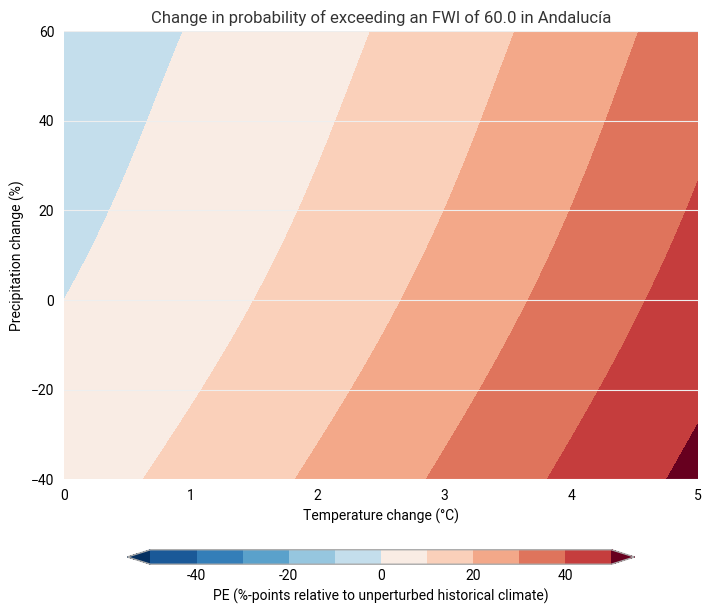

In [16]:
pe_plot_style_relative = ekp.styles.Style(
    levels=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50],
    extend="both",
    colors="RdBu_r",
    units_label="%-points relative to unperturbed historical climate"
)

subplot = ekp.Subplot()
subplot.title(f"Change in probability of exceeding an FWI of {threshold} in {location}")

subplot.contourf(relative_response(pe_response_sampled), style=pe_plot_style_relative)
subplot.legend()

subplot.ax.set_xlabel("Temperature change (°C)")
subplot.ax.set_ylabel("Precipitation change (%)")

Note how the 0-contour (no change) passess through the point with zero temperature and precipitation change on the left, which represents the unperturbed historical climate.

## Step 4: Response surface for fire season length

The same response surface methodology can be applied to other properties of the FWI simulations.
Here, the steps are repeated for the average fire season length (FSL), as defined by the number of days in a year where the FWI exceeds a threshold.

The threshold value is again chosen as half the value of the 20-year return period in the unperturbed historical simulation, following [El Garroussi et al. (2024)](https://doi.org/10.1038/s41612-024-00575-8).

### Threshold selection

In [17]:
fwi_20yr = ekm_stats.return_period_to_value(
    ekm_stats.GumbelDistribution.fit(fwi_max.sel({"dp": 0.0, "dt": 0.0})),
    20.  # return period in years
)

# Use half the 20-year return period FWI as threshold; round for nicer labels
fsl_threshold = round(0.5 * fwi_20yr, 1)
fsl_threshold

32.7

### Response table

In [18]:
fsl = (location_fwi > fsl_threshold).groupby(location_fwi.coords["time"].dt.year).sum()

fsl_response = fsl.mean(dim="year").to_series().rename("FSL")

In [19]:
fsl_response.unstack().round(1)

dt,0.0,1.0,2.0,3.0,4.0,5.0
dp,,,,,,
-40.0,99.2,103.7,107.9,111.9,116.1,119.8
-20.0,92.3,97.0,101.3,105.4,109.2,112.8
0.0,87.1,91.4,95.9,100.0,103.9,107.8
20.0,83.5,87.5,91.1,95.6,99.5,103.5
40.0,79.9,84.0,87.8,92.0,95.9,99.7
60.0,76.9,81.1,85.0,88.9,92.8,96.5


### Response surface

In [20]:
fsl_response_model = fit_response_surface(fsl_response, "FSL", degree=4)

fsl_response_sampled = pd.DataFrame(
    fsl_response_model.predict(sample.to_frame()),
    index=sample,
    columns=["FSL"]
).to_xarray()

Text(0, 0.5, 'Precipitation change (%)')

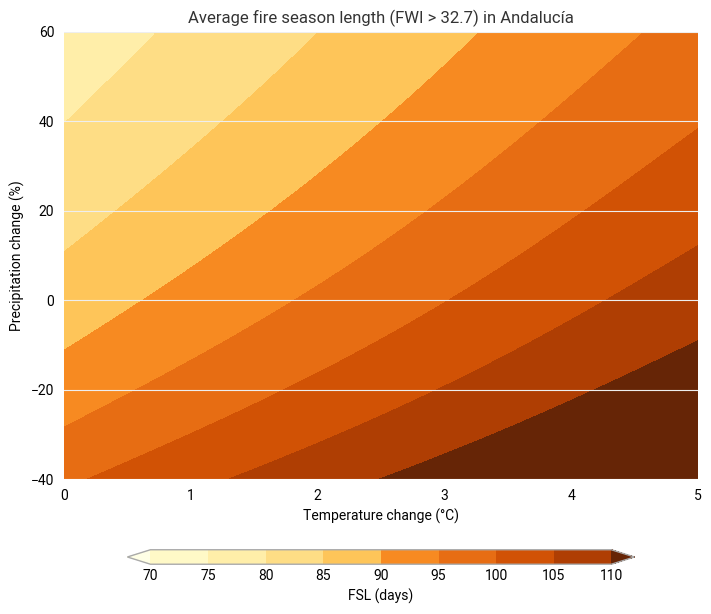

In [21]:
fsl_plot_style_absolute = ekp.styles.Style(
    levels=[70, 75, 80, 85, 90, 95, 100, 105, 110],  # adapt to your data range
    extend="both",
    colors="YlOrBr",
    units_label="days"
)

subplot = ekp.Subplot()
subplot.title(f"Average fire season length (FWI > {fsl_threshold}) in {location}")

subplot.contourf(fsl_response_sampled, style=fsl_plot_style_absolute)
subplot.legend()

subplot.ax.set_xlabel("Temperature change (°C)")
subplot.ax.set_ylabel("Precipitation change (%)")

## Step 5: Export data and models

Each response model is written to a dedicated folder.
Export response tables in csv format, models with [pickle](https://scikit-learn.org/stable/model_persistence.html#pickle-joblib-and-cloudpickle) and metadata as json.

In [22]:
def export_all(name, table, model, info):
    out_dir = data_dir / location / name
    out_dir.mkdir(parents=True, exist_ok=True)

    table.to_csv(out_dir / "response_table.csv")

    with open(out_dir / "response_model.pkl", "wb") as f:
        pickle.dump(model, f, protocol=5)

    with open(out_dir / "response_info.json", "w") as f:
        json.dump(info, f)

    return name

### Probability of exceedance

In [23]:
export_all(f"hazard_pe_{threshold}", pe_response, pe_response_model, {
    "location": location,
    "threshold": threshold,
    "variable": "pe",
    "label": f"probability of exceeding FWI {threshold} in a year",
    "units": "%"
})

'hazard_pe_60.0'

### Fire season length

In [24]:
export_all(f"hazard_fsl_{fsl_threshold}", fsl_response, fsl_response_model, {
    "location": location,
    "threshold": fsl_threshold,
    "variable": "fsl",
    "label": f"average fire season length (FWI ≥ {fsl_threshold})",
    "units": "days"
})

'hazard_fsl_32.7'

## Summary

Response surface models for two FWI-based fire hazard indicators,

- the probability of exceedance of an FWI threshold in a year (inverse return period) and
- the average number of days above an FWI threshold in a year (fire season length),

have been created based on the perturbed historical simulations of [El Garroussi (2024)](https://doi.org/10.5281/zenodo.10458186).
These response surfaces give insight into the individual and synergistic impact of temperature and precipitation changes on wildfire hazard in a region of interest, allowing for a first assessment of how susceptible to climate change a region is in terms of wildfire hazard.

:::{tip}

In principle, the response surface methodology works with any quantity that breaks down each simulation from the dataset to a single number.
Here, we have chosen to apply the method to the probability of exceedance of a threshold and the average fire season length.
You can repeat the steps with any suitable quantity of interest.
:::

In the next part of the hazard assessment ([climate projections](hazard_assessment_projections.ipynb)), projections of temperature and precipitation change from climate model runs are evaluated with a response model to obtain concrete projections of wildfire hazard for the future.